In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
import itertools

In [2]:
def anti_lorenz(t, y):
    return np.array([
        7*(y[4] - y[0]),
        y[0]*(10 - y[2]) - y[1],
        y[0]*y[1] - 8/3 * y[5],
        7*(y[1] - y[3]),
        y[3]*(10 - y[5]) - y[4],
        y[3]*y[4] - 8/3 * y[2]
    ])

In [3]:
y0 = np.random.random(6)
t_span=(-10,100)

sol = solve_ivp(anti_lorenz, t_span, y0, max_step=0.005)


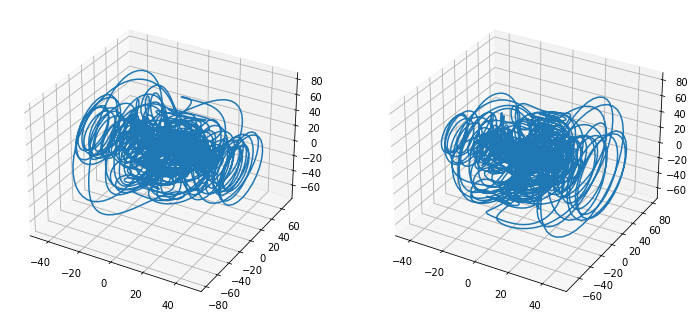

In [4]:
t0_i = np.argmax(sol.t >= 0)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax1.plot(sol.y[0,t0_i:], sol.y[1,t0_i:], sol.y[2,t0_i:])
ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.plot(sol.y[3,t0_i:], sol.y[4,t0_i:], sol.y[5,t0_i:])
plt.show()


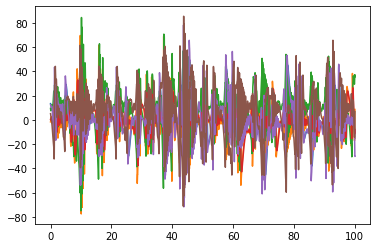

In [5]:
plt.plot(sol.t[t0_i:],sol.y[:,t0_i:].T)
plt.show()

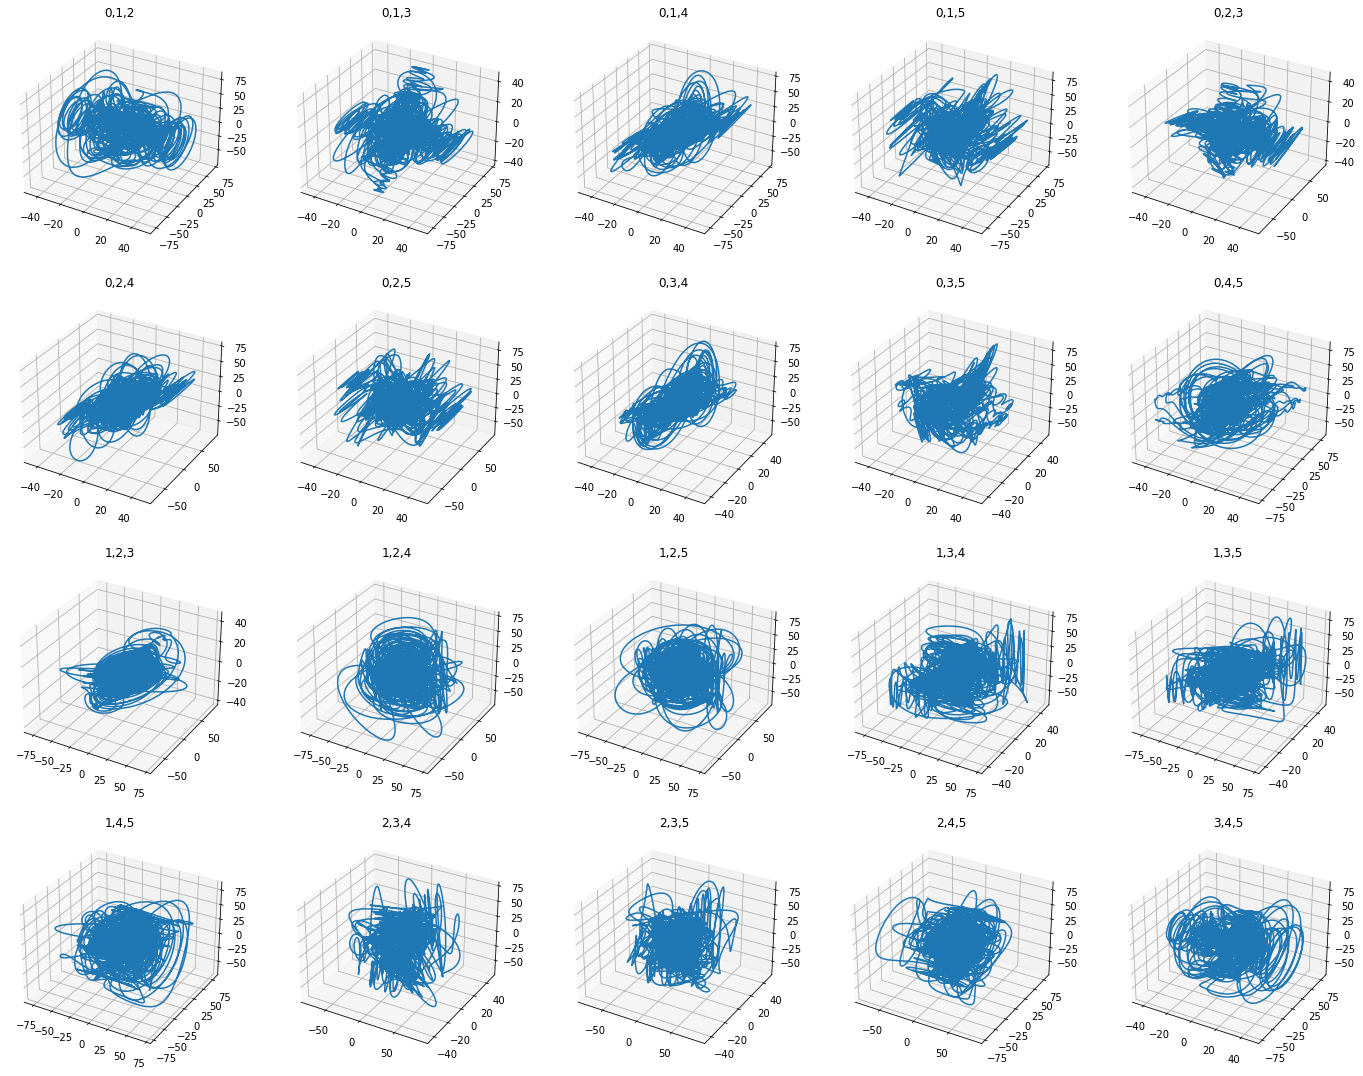

In [6]:
permutations = list(itertools.combinations(range(6), 3))
n = int(np.ceil(np.sqrt(len(permutations))))
t0_i = np.argmax(sol.t >= 0)
fig = plt.figure(figsize=(24,24))

for idx,(i,j,k) in enumerate(permutations):
    ax = fig.add_subplot(n,n,idx+1,projection='3d')
    ax.plot(sol.y[i,t0_i:], sol.y[j,t0_i:], sol.y[k,t0_i:])
    ax.set_title('{},{},{}'.format(i,j,k))
    
plt.show()

In [8]:
from rescomp import optimizer as rcopt

In [33]:
class AntiLorenzSystem(rcopt.System):
    """Implements the ball-of-yarn system defined above for rescomp use"""
    def __init__(self):
        super().__init__('AntiLorenz', 10, 15, 0.005, 6, is_diffeq=True)
        self.transient_time=20
        
    def _get_proper_ic(self):
        """Returns an initial condition that is (hopefully) on the attractor"""
        y0 = np.random.random(6)*10
        sol = solve_ivp(self.df_eq, (0,self.transient_time), y0)
        return sol.y[:,-1]
        
    def df_eq(self, t, y, D=None):
        return np.array([
            7*(y[4] - y[0]),
            y[0]*(10 - y[2]) - y[1],
            y[0]*y[1] - 8/3 * y[5],
            7*(y[1] - y[3]),
            y[3]*(10 - y[5]) - y[4],
            y[3]*y[4] - 8/3 * y[2]
        ])
    def get_train_test_data(self, cont_test=True):
        #Get train data
        y0 = self._get_proper_ic()
        tr = np.arange(0., self.train_time, self.dt)
        sol_tr = solve_ivp(self.df_eq, (0,self.train_time), y0, t_eval=tr)
        
        #Get initial condition for test data
        if cont_test:
            y0_2 = sol_tr.y[:,-1]
        else:
            y0_2 = self._get_proper_ic()
        #Get test data
        ts = np.arange(0., self.test_time, self.dt)
        sol_ts = solve_ivp(self.df_eq, (0,self.test_time), y0_2, t_eval=ts)
        
        return tr, sol_tr.y.T, ts, sol_ts.y.T
    
    def get_random_test(self):
        #Get test data
        y0_2 = self._get_proper_ic()
        ts = np.arange(0., self.test_time, self.dt)
        sol_ts = solve_ivp(self.df_eq, (0,self.test_time), y0_2, t_eval=ts)
        
        return ts, sol_ts.y.T
        

In [41]:
al_system = AntiLorenzSystem()
optimizer = rcopt.ResCompOptimizer(al_system, 'activ_f', 'continue', 'standard')
parameters = {'sigma': 0.01,
 'gamma': 25.0,
 'ridge_alpha': 1e-08,
 'spect_rad': 4.060882064610251,
 'mean_degree': 2.079117239034718}
data = optimizer.generate_orbits(40, parameters)
vpts = [rcopt.get_vptime(al_system, ts, Uts, pre) for tr,Utr,ts,Uts,pre in data]

No prior found for system AntiLorenz; using empty prior instead.


In [43]:
print(vpts)
print(np.mean(vpts))
print(np.std(vpts))

[1.1300000000000001, 1.42, 0.425, 0.29, 0.75, 1.985, 0.46, 0.915, 0.885, 1.03, 1.195, 1.3800000000000001, 0.705, 0.74, 1.33, 0.9550000000000001, 0.365, 0.76, 0.8250000000000001, 1.2750000000000001, 0.595, 0.795, 0.625, 0.885, 1.18, 1.385, 1.47, 0.73, 0.56, 0.91, 0.61, 0.445, 1.0150000000000001, 0.715, 1.05, 0.79, 0.79, 1.665, 1.705, 1.25]
0.9497499999999999
0.38593385119732626


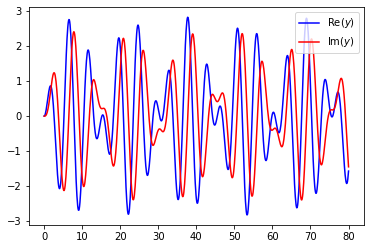

In [61]:
u = lambda t: np.sin(t*1.41425)
ode = lambda t,y: (1j*y) + u(t)

sol = solve_ivp(ode, (0,80), [0+0j], max_step=0.1)

plt.plot(sol.t, np.real(sol.y.T), 'b-', label='Re($y$)')
plt.plot(sol.t, np.imag(sol.y.T), 'r-', label='Im($y$)')
plt.legend()
plt.show()

In [55]:
s